In [8]:
from scipy import *
from numpy import *
from matplotlib import *
from matplotlib.pyplot import *
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from scipy.signal import savgol_filter
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
# year month format for plotting
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
from statsmodels.tsa.seasonal import seasonal_decompose
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [9]:

df = pd.read_csv('AAPL.csv') # usecols=[0,4]
#clean data file ->  'null' in few rows! 
df.dropna(subset=['Close'], inplace=True)
l1 = len(df) 
df.tail(4)
#print(l1)

,Date,Open,High,Low,Close,Adj Close,Volume
248,2021-09-03,153.759995,154.630005,153.089996,154.300003,154.300003,57808700
249,2021-09-07,154.970001,157.259995,154.389999,156.690002,156.690002,82278300
250,2021-09-08,156.979996,157.039993,153.979996,155.110001,155.110001,74420200
251,2021-09-09,155.490005,156.110001,153.949997,154.070007,154.070007,57305730


In [10]:
def test_stationarity(timeseries):
    print("Results from Dickey Fuller Test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','No. of obser. used'])
    for key, values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df['Close'])

Results from Dickey Fuller Test
Test Statistics          -1.136651
p-value                   0.700237
No. of lags used          0.000000
No. of obser. used      251.000000
critical value (1%)      -3.456674
critical value (5%)      -2.873125
critical value (10%)     -2.572944
dtype: float64


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1500.386, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1500.955, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1501.123, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1501.634, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1499.454, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.375 seconds


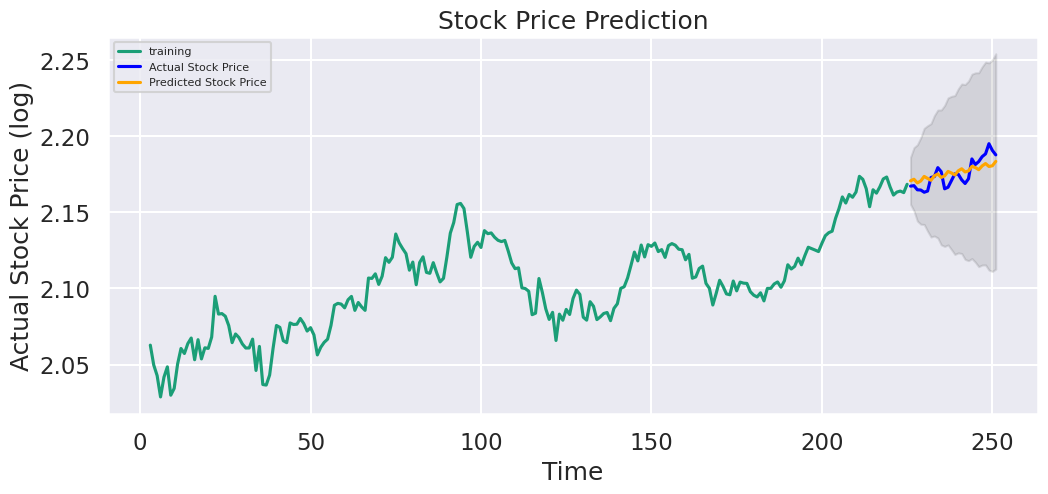

In [11]:
df_log = np.log10(abs(df['Close']))
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,test='adf',max_p=3, max_q=3, m=1,              
                      d=None,seasonal=False, start_P=0, D=0, trace=True,error_action='ignore',  
                      suppress_warnings=True, stepwise=True)

# Forecast
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  

l2 = len(test_data)
fc, se, conf = fitted.forecast(l2, alpha=0.05)  # 95% confidence

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price (log)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

<Figure size 432x288 with 0 Axes>

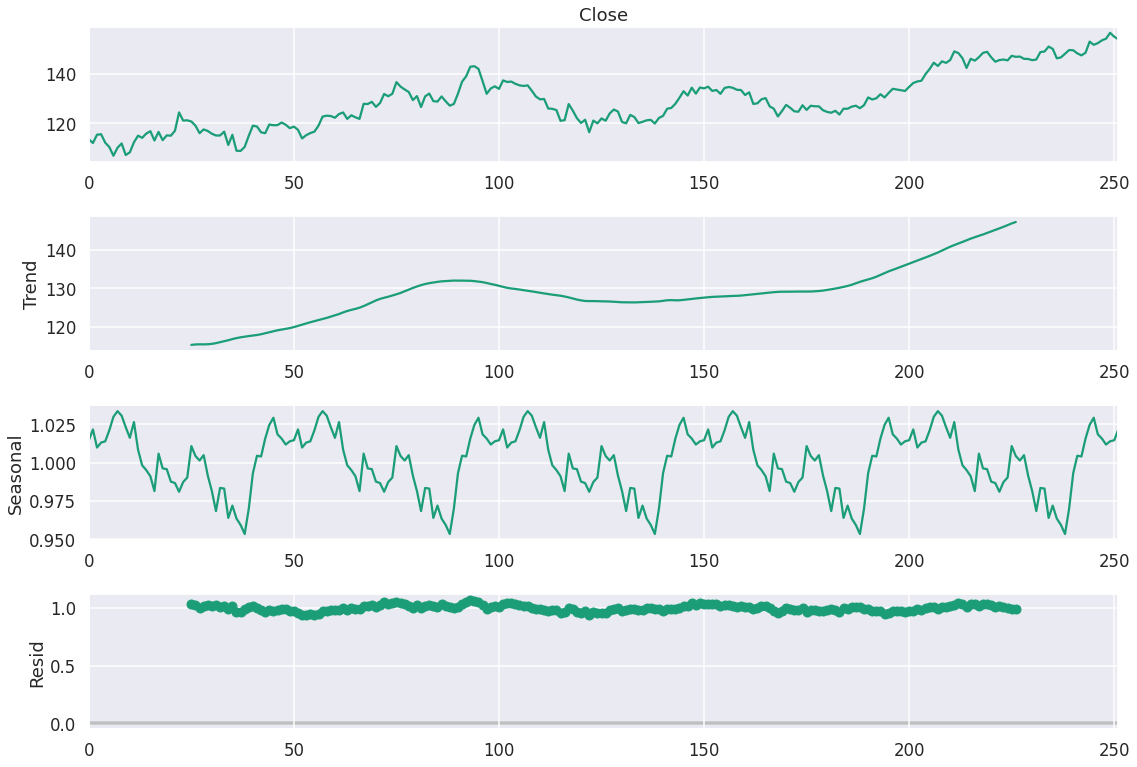

In [12]:
decom= seasonal_decompose(df['Close'], model='multiplicative', freq = 50)
fig = plt.figure()  
fig = decom.plot()  
fig.set_size_inches(16, 11)
plt.tight_layout()